In [1]:
################################################################################
# CELL 1: Installation, Imports, and Preprocessing
################################################################################
# نصب کتابخانه‌های مورد نیاز
!pip install -q torch transformers peft bitsandbytes pandas tqdm accelerate hazm matplotlib seaborn

import torch
import pandas as pd
import numpy as np
import re
import hazm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split # فقط برای تقسیم اگر فایل‌ها جدا نباشند

# تنظیم دستگاه
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- کلاس پیش‌پردازشگر (اصلاح شده برای نسخه جدید Hazm) ---
class PersianPreprocessor:
    def __init__(self):
        # حذف پارامتر unify_punctuation که در نسخه‌های جدید حذف شده است
        self.normalizer = hazm.Normalizer(
            persian_style=False,
            persian_numbers=False,
            remove_diacritics=True
        )
    
    def clean_text(self, text):
        if not isinstance(text, str): return ""
        try:
            text = self.normalizer.normalize(text)
        except:
            pass
        # حذف کشیدگی حروف و کاراکترهای مزاحم
        text = re.sub(r'(\S)\1{2,}', r'\1', text)
        text = re.sub(r'[^\w\s\.\u200c\u200f]+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# --- بارگذاری و پردازش داده‌ها ---
print("Loading and cleaning data...")
# [cite_start]# [cite: 23, 24]
try:
    train_df = pd.read_csv('/kaggle/input/poemss/Train.csv')
    val_df = pd.read_csv('/kaggle/input/poemss/Val.csv')
    test_df = pd.read_csv('/kaggle/input/poemss/Test.csv')
except FileNotFoundError:
    print("Files not found! Please upload Train.csv, Val.csv, Test.csv")
    # ایجاد دامی دیتا برای جلوگیری از کرش کردن کد در صورت نبود فایل
    train_df = pd.DataFrame({'text': ['شعر تست'], 'poet': ['شاعر']})
    val_df = train_df.copy()
    test_df = train_df.copy()

# preprocessor = PersianPreprocessor()

# # [cite_start]اعمال پیش‌پردازش [cite: 28]
# for df, name in zip([train_df, val_df, test_df], ['Train', 'Val', 'Test']):
#     tqdm.pandas(desc=f"Cleaning {name}")
#     df['text'] = df['text'].progress_apply(preprocessor.clean_text)
#     # حذف داده‌های بسیار کوتاه
#     df.drop(df[df['text'].str.len() < 5].index, inplace=True)

# ایجاد نگاشت برچسب‌ها
unique_poets = train_df['poet'].unique()
label2id = {label: i for i, label in enumerate(unique_poets)}
id2label = {i: label for label, i in label2id.items()}
num_labels = len(unique_poets)

print(f"Classes (Poets): {num_labels}")
print("Data ready.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 32.8 MB

In [ ]:
################################################################################
# CELL 2: Metrics, Dataset Class, and Analysis Functions
################################################################################
from torch.utils.data import Dataset, DataLoader

def calculate_f1_scratch(preds, labels, num_classes):
    cm = [[0]*num_classes for _ in range(num_classes)]
    for p, l in zip(preds, labels):
        cm[l][p] += 1
    
    tp = [cm[i][i] for i in range(num_classes)]
    fp = [sum(cm[j][i] for j in range(num_classes)) - tp[i] for i in range(num_classes)]
    fn = [sum(cm[i][j] for j in range(num_classes)) - tp[i] for i in range(num_classes)]
    
    # Macro F1
    f1s = []
    for i in range(num_classes):
        denom = 2*tp[i] + fp[i] + fn[i]
        f1s.append(2*tp[i]/denom if denom > 0 else 0)
    macro_f1 = sum(f1s) / num_classes
    
    # Micro F1
    total_tp, total_fp, total_fn = sum(tp), sum(fp), sum(fn)
    micro_denom = 2*total_tp + total_fp + total_fn
    micro_f1 = 2*total_tp / micro_denom if micro_denom > 0 else 0
    
    return micro_f1, macro_f1, cm

# --- کلاس دیتاست ---
class PoemDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['text'].tolist()
        self.labels = [label2id[l] for l in df['poet'].tolist()]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]), truncation=True, padding="max_length",
            max_length=self.max_len, return_tensors="pt"
        )
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# --- تابع تحلیل جامع (بخش 5) ---
def run_analysis(model, test_loader, title, num_labels):
    print(f"\n>>> Running Analysis for: {title} ")
    model.eval()
    all_preds, all_labels = [], []
    
    # استخراج predictions
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].numpy())
            
    # محاسبه متریک‌ها
    micro, macro, cm = calculate_f1_scratch(all_preds, all_labels, num_labels)
    
    print(f"\n--- {title} Results ---")
    print(f"Micro F1: {micro:.4f}")
    print(f"Macro F1: {macro:.4f}")
    
    # تحلیل کلاس‌ها (بهترین و بدترین) 
    acc_per_class = {}
    for i in range(num_labels):
        total = sum(cm[i])
        acc_per_class[id2label[i]] = cm[i][i] / total if total > 0 else 0
    
    sorted_acc = sorted(acc_per_class.items(), key=lambda x: x[1])
    print(f"Worst Class: {sorted_acc[0]}")
    print(f"Best Class: {sorted_acc[-1]}")
    
    # رسم Confusion Matrix 
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[id2label[i] for i in range(num_labels)],
                yticklabels=[id2label[i] for i in range(num_labels)])
    plt.title(f"Confusion Matrix - {title}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

2025-12-12 16:22:33.575799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765556553.757473      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765556553.800138      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


=============== LoRA Training (Rank 8) ===============


tokenizer_config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at codelion/gpt-2-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Trainable Parameters: 550,912 || All Params: 64,646,656 || Trainable%: 0.85%


Epoch 1: 100%|██████████| 313/313 [01:03<00:00,  4.91it/s]


Epoch 1 Val Loss: 1.5676


Epoch 2: 100%|██████████| 313/313 [01:02<00:00,  4.98it/s]


Epoch 2 Val Loss: 1.3105


Epoch 3: 100%|██████████| 313/313 [01:02<00:00,  4.98it/s]


Epoch 3 Val Loss: 1.2243


Epoch 4: 100%|██████████| 313/313 [01:02<00:00,  4.97it/s]


Epoch 4 Val Loss: 1.0711


Epoch 5: 100%|██████████| 313/313 [01:02<00:00,  4.98it/s]


Epoch 5 Val Loss: 1.0308

[REPORT - Rank 8]
Training Time: 410.00 seconds
Max Memory Used: 3.72 GB
------------------------------

>>> Running Analysis for: LoRA (Rank=8) 


Testing: 100%|██████████| 63/63 [00:07<00:00,  8.20it/s]



--- LoRA (Rank=8) Results ---
Micro F1: 0.6880
Macro F1: 0.4892
Worst Class: ('امیرعلیشیر نوایی', 0.0)
Best Class: ('رضاقلی خان هدایت', 0.9047619047619048)


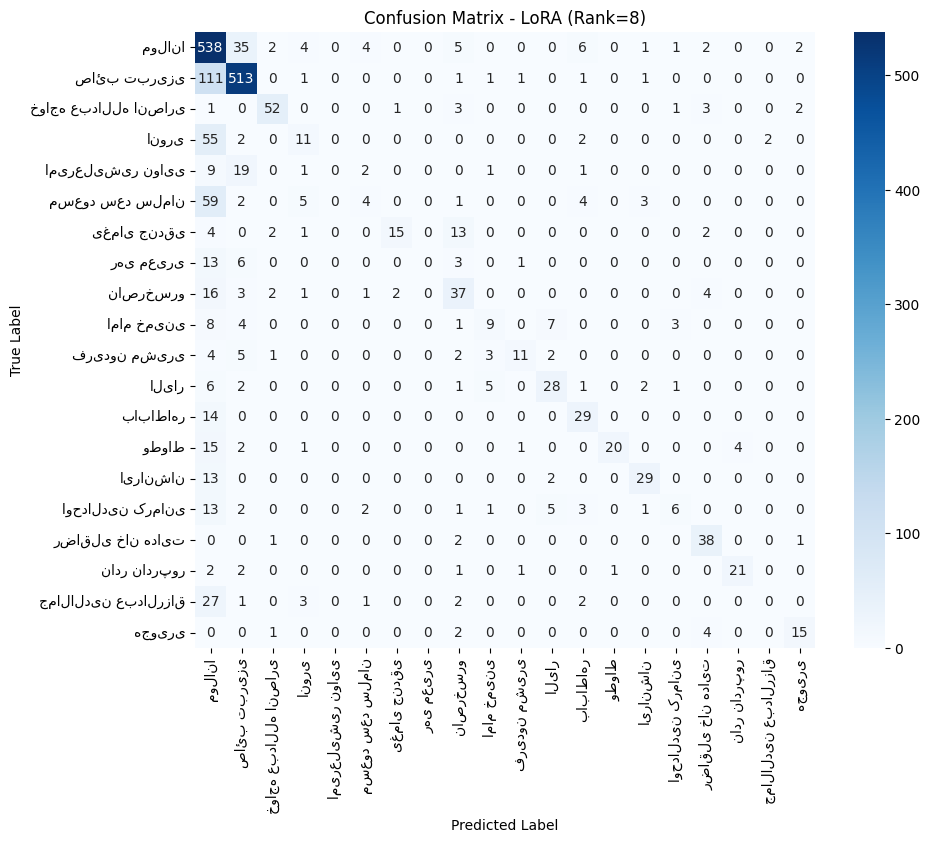


=============== LoRA Training (Rank 16) ===============


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at codelion/gpt-2-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Trainable Parameters: 1,091,584 || All Params: 65,187,328 || Trainable%: 1.67%


Epoch 1: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


Epoch 1 Val Loss: 1.4568


Epoch 2: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


Epoch 2 Val Loss: 1.2180


Epoch 3: 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


Epoch 3 Val Loss: 1.1194


Epoch 4: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


Epoch 4 Val Loss: 0.9795


Epoch 5: 100%|██████████| 313/313 [01:03<00:00,  4.93it/s]


Epoch 5 Val Loss: 0.9557

[REPORT - Rank 16]
Training Time: 417.57 seconds
Max Memory Used: 3.74 GB
------------------------------

>>> Running Analysis for: LoRA (Rank=16) 


Testing: 100%|██████████| 63/63 [00:08<00:00,  7.61it/s]



--- LoRA (Rank=16) Results ---
Micro F1: 0.7130
Macro F1: 0.5227
Worst Class: ('امیرعلیشیر نوایی', 0.0)
Best Class: ('صائب تبریزی', 0.9079365079365079)


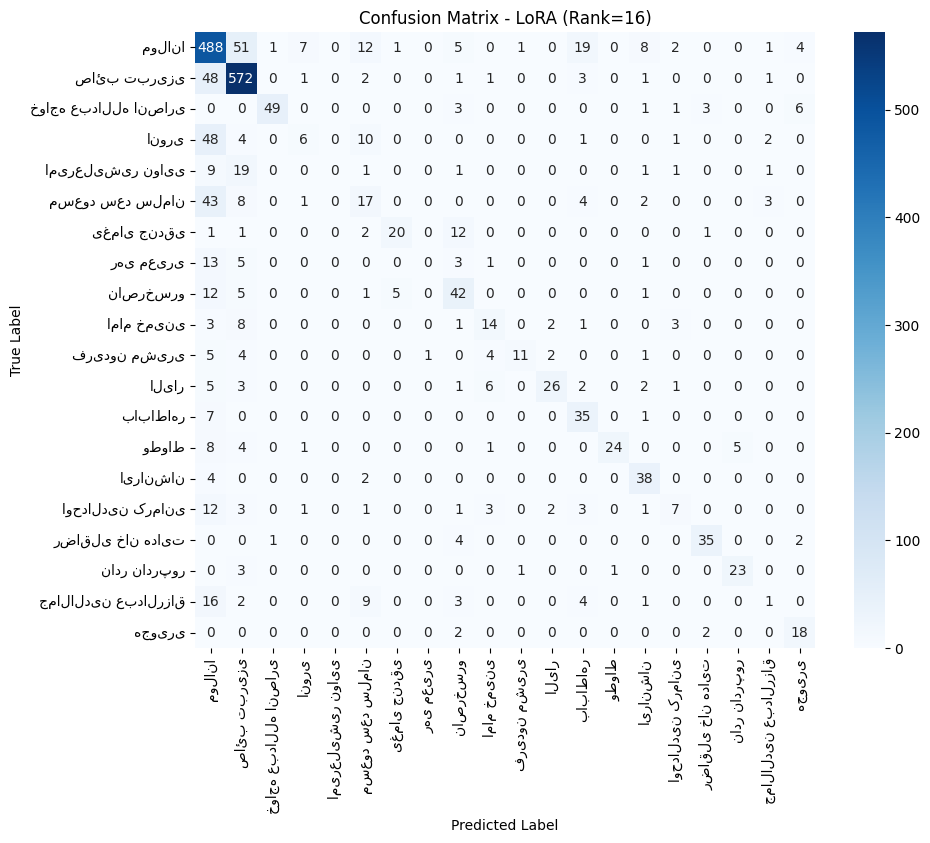

In [3]:
################################################################################
# CELL 3 (FIXED for GPT-2): LoRA Training & Analysis
################################################################################
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
import time

def train_lora_experiment(rank_r, model_name="codelion/gpt-2-70m"):
    print(f"\n{'='*15} LoRA Training (Rank {rank_r}) {'='*15}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels, id2label=id2label, label2id=label2id,
        device_map="auto" 
    )
    model.config.pad_token_id = tokenizer.pad_token_id

    # --- اصلاح مهم: نام لایه‌های GPT-2 ---
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, 
        r=rank_r, 
        lora_alpha=rank_r*2, 
        lora_dropout=0.1,
        # در GPT-2: c_attn شامل Q,K,V است و c_proj همان O است
        target_modules=["c_attn", "c_proj"], 
        modules_to_save=["score"]
    )
    
    model = get_peft_model(model, peft_config)
    
    trainable_params, all_params = model.get_nb_trainable_parameters()
    print(f"Trainable Parameters: {trainable_params:,} || All Params: {all_params:,} || Trainable%: {100 * trainable_params / all_params:.2f}%")
    
    train_loader = DataLoader(PoemDataset(train_df, tokenizer), batch_size=32, shuffle=True) # بچ سایز بیشتر برای مدل کوچک
    val_loader = DataLoader(PoemDataset(val_df, tokenizer), batch_size=32)
    test_loader = DataLoader(PoemDataset(test_df, tokenizer), batch_size=32)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    criterion = torch.nn.CrossEntropyLoss()
    best_loss = float('inf')
    patience_counter = 0
    
    torch.cuda.reset_peak_memory_stats()
    start_train_time = time.time()
    
    for epoch in range(5):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            loss = criterion(outputs.logits, batch['labels'].to(model.device))
            loss.backward()
            optimizer.step()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
                outputs = model(**inputs)
                val_loss += criterion(outputs.logits, batch['labels'].to(model.device)).item()
        
        avg_val = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} Val Loss: {avg_val:.4f}")
        
        if avg_val < best_loss:
            best_loss = avg_val
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 1:
                print("Early stopping triggered.")
                break
    
    end_train_time = time.time()
    training_duration = end_train_time - start_train_time
    max_memory_used = torch.cuda.max_memory_allocated() / (1024 ** 3)
    
    print(f"\n[REPORT - Rank {rank_r}]")
    print(f"Training Time: {training_duration:.2f} seconds")
    print(f"Max Memory Used: {max_memory_used:.2f} GB")
    print("-" * 30)

    run_analysis(model, test_loader, f"LoRA (Rank={rank_r})", num_labels)
    
    del model
    torch.cuda.empty_cache()

# اجرای آزمایش‌ها
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

train_lora_experiment(rank_r=8)
train_lora_experiment(rank_r=16)


=============== QLoRA Training (Rank 8) ===============


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at codelion/gpt-2-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 550,912 || All Params: 64,646,656 || Trainable%: 0.85%


Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 1: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch 1 Val Loss: 1.5814


Epoch 2: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 2 Val Loss: 1.2923


Epoch 3: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 3 Val Loss: 1.1118


Epoch 4: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 4 Val Loss: 1.0820


Epoch 5: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch 5 Val Loss: 1.0481

[REPORT - Rank 8]
Training Time: 572.17 seconds
Max Memory Used: 0.89 GB
------------------------------

>>> Running Analysis for: QLoRA (Rank=8) 


Testing: 100%|██████████| 63/63 [00:08<00:00,  7.44it/s]



--- QLoRA (Rank=8) Results ---
Micro F1: 0.6910
Macro F1: 0.4714
Worst Class: ('امیرعلیشیر نوایی', 0.0)
Best Class: ('هجویری', 0.9545454545454546)


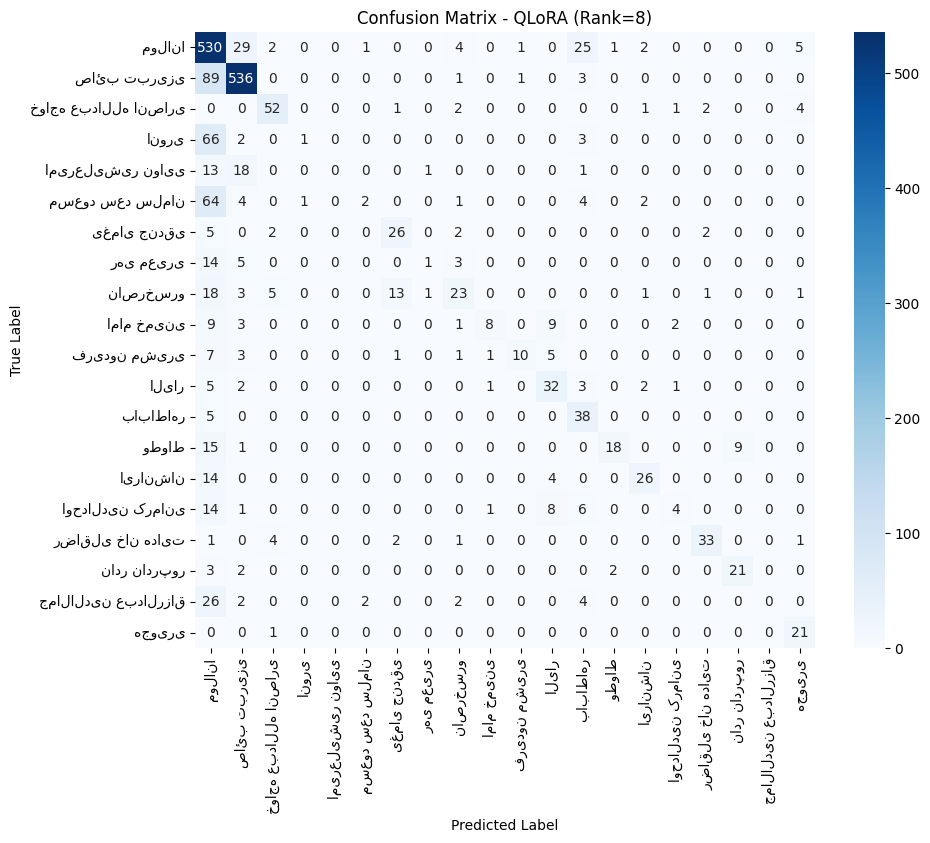


=============== QLoRA Training (Rank 16) ===============


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at codelion/gpt-2-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 1,091,584 || All Params: 65,187,328 || Trainable%: 1.67%


Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 1: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 1 Val Loss: 1.4352


Epoch 2: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 2 Val Loss: 1.2540


Epoch 3: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 3 Val Loss: 1.0679


Epoch 4: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 4 Val Loss: 0.9979


Epoch 5: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 5 Val Loss: 0.9442

[REPORT - Rank 16]
Training Time: 573.46 seconds
Max Memory Used: 0.92 GB
------------------------------

>>> Running Analysis for: QLoRA (Rank=16) 


Testing: 100%|██████████| 63/63 [00:08<00:00,  7.34it/s]



--- QLoRA (Rank=16) Results ---
Micro F1: 0.7095
Macro F1: 0.5254
Worst Class: ('امیرعلیشیر نوایی', 0.0)
Best Class: ('رضاقلی خان هدایت', 0.9761904761904762)


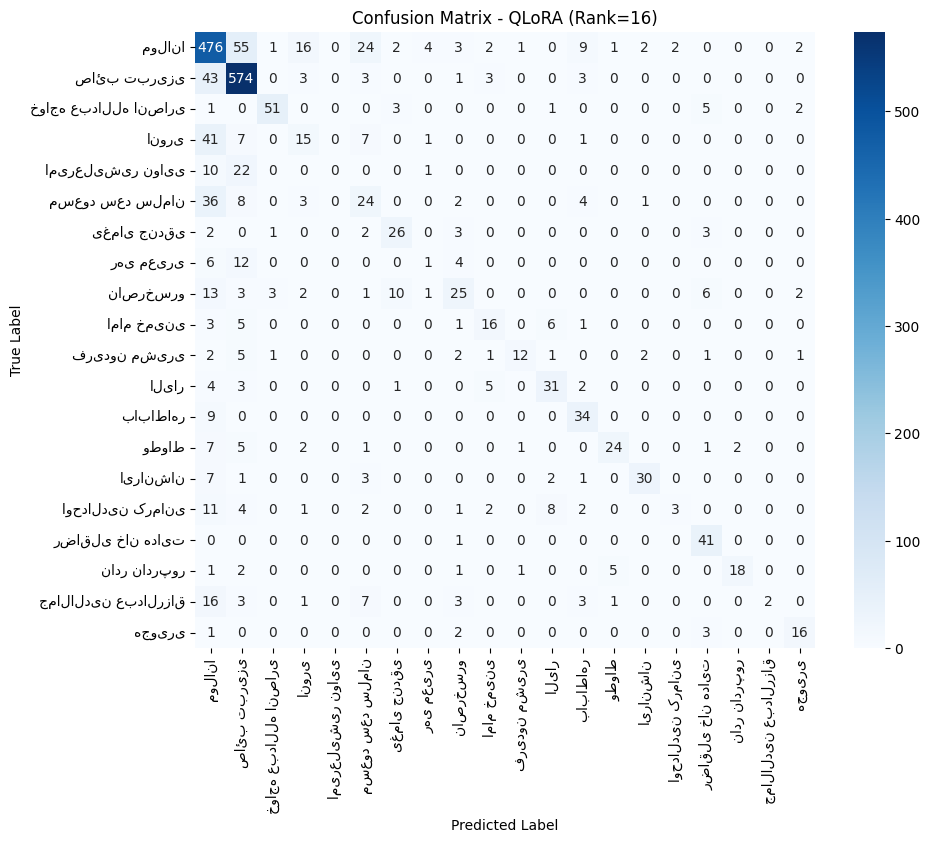

In [ ]:
################################################################################
# CELL 4 (FIXED for GPT-2): QLoRA Training & Analysis
################################################################################
from transformers import BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

def train_qlora_experiment(rank_r, model_name="codelion/gpt-2-70m"):
    print(f"\n{'='*15} QLoRA Training (Rank {rank_r}) {'='*15}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
    
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels, id2label=id2label, label2id=label2id,
        quantization_config=bnb_config, device_map="auto"
    )
    model.config.pad_token_id = tokenizer.pad_token_id
    model = prepare_model_for_kbit_training(model)
    
    # --- اصلاح مهم: نام لایه‌های GPT-2 ---
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, 
        r=rank_r, 
        lora_alpha=rank_r*2, 
        lora_dropout=0.1,
        target_modules=["c_attn", "c_proj"], # نام‌های صحیح برای GPT-2
        modules_to_save=["score"]
    )
    
    model = get_peft_model(model, peft_config)
    
    trainable_params, all_params = model.get_nb_trainable_parameters()
    print(f"Trainable Parameters: {trainable_params:,} || All Params: {all_params:,} || Trainable%: {100 * trainable_params / all_params:.2f}%")
    
    train_loader = DataLoader(PoemDataset(train_df, tokenizer), batch_size=32, shuffle=True)
    val_loader = DataLoader(PoemDataset(val_df, tokenizer), batch_size=32)
    test_loader = DataLoader(PoemDataset(test_df, tokenizer), batch_size=32)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    criterion = torch.nn.CrossEntropyLoss()
    best_loss = float('inf')
    patience_counter = 0
    
    torch.cuda.reset_peak_memory_stats()
    start_train_time = time.time()
    
    for epoch in range(5):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            labels = batch['labels'].to(model.device) 
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                labels = batch['labels'].to(model.device)
                inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
                outputs = model(**inputs)
                val_loss += criterion(outputs.logits, labels).item()
        
        avg_val = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} Val Loss: {avg_val:.4f}")
        
        if avg_val < best_loss:
            best_loss = avg_val
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 1:
                print("Early stopping triggered.")
                break

    end_train_time = time.time()
    training_duration = end_train_time - start_train_time
    max_memory_used = torch.cuda.max_memory_allocated() / (1024 ** 3)
    
    print(f"\n[REPORT - Rank {rank_r}]")
    print(f"Training Time: {training_duration:.2f} seconds")
    print(f"Max Memory Used: {max_memory_used:.2f} GB")
    print("-" * 30)

    run_analysis(model, test_loader, f"QLoRA (Rank={rank_r})", num_labels)
    
    del model
    torch.cuda.empty_cache()

# اجرای آزمایش‌ها
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
train_qlora_experiment(rank_r=8)
train_qlora_experiment(rank_r=16)